In [1]:
!pip install -q diffusers transformers accelerate peft datasets bitsandbytes safetensors pillow torchvision
!pip install -q git+https://github.com/huggingface/transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import torch
from PIL import Image
from tqdm import tqdm

from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import LoraConfig, get_peft_model


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
from google.colab import files
import os

os.makedirs("dataset", exist_ok=True)

uploaded = files.upload()

for file_name in uploaded.keys():
    os.rename(file_name, f"dataset/{file_name}")


Saving img_01.jpg to img_01.jpg
Saving img_02.jpg to img_02.jpg
Saving img_03.jpg to img_03.jpg
Saving img_04.jpg to img_04.jpg
Saving img_05.jpg to img_05.jpg
Saving img_06.jpg to img_06.jpg
Saving img_07.jpg to img_07.jpg
Saving img_08.jpg to img_08.jpg
Saving img_09.jpg to img_09.jpg
Saving img_10.jpg to img_10.jpg
Saving img_11.jpg to img_11.jpg
Saving img_12.jpg to img_12.jpg
Saving img_13.jpg to img_13.jpg
Saving img_14.jpg to img_14.jpg
Saving img_15.jpg to img_15.jpg
Saving img_16.jpg to img_16.jpg
Saving img_17.jpg to img_17.jpg
Saving img_18.jpg to img_18.jpg
Saving img_19.jpg to img_19.jpg
Saving img_20.jpg to img_20.jpg
Saving img_21.jpg to img_21.jpg
Saving img_22.jpg to img_22.jpg


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base"
)

caption_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

In [5]:
dataset_path = "dataset"
captions = []

for img_name in tqdm(os.listdir(dataset_path)):

    img_path = os.path.join(dataset_path, img_name)
    raw_image = Image.open(img_path).convert("RGB")

    inputs = processor(raw_image, return_tensors="pt").to(device)

    out = caption_model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    captions.append({
        "image": img_path,
        "caption": caption
    })

captions[:3]


100%|██████████| 22/22 [00:12<00:00,  1.82it/s]


[{'image': 'dataset/img_17.jpg',
  'caption': 'a man in a suit and tie sitting at a table'},
 {'image': 'dataset/img_11.jpg',
  'caption': 'a man in a suit standing next to a car'},
 {'image': 'dataset/img_13.jpg',
  'caption': 'a man standing at a podium with flowers in front of him'}]

In [6]:
import json

with open("captions.json", "w") as f:
    json.dump(captions, f, indent=2)


In [7]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(device)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [8]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["to_q", "to_k", "to_v"],
    lora_dropout=0.1
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()


trainable params: 1,195,008 || all params: 860,715,972 || trainable%: 0.1388


In [15]:
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=1e-5)

pipe.unet.train()

for epoch in range(2):

    for item in tqdm(captions):

        image = Image.open(item["image"]).convert("RGB")
        prompt = item["caption"]

        image = pipe.image_processor.preprocess(image)
        image = image.to(device=device, dtype=pipe.vae.dtype)

        with torch.no_grad():
            latents = pipe.vae.encode(image).latent_dist.sample()

        latents = latents * 0.18215
        latents = latents.to(device=device, dtype=pipe.unet.dtype)

        noise = torch.randn_like(latents)

        timesteps = torch.randint(0, 1000, (1,), device=device).long()

        noisy_latents = latents + noise

        prompt_embeds, _ = pipe.encode_prompt(
            prompt,
            device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=False
        )

        prompt_embeds = prompt_embeds.to(pipe.unet.dtype)

        noise_pred = pipe.unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=prompt_embeds
        ).sample

        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch", epoch, "Loss:", loss.item())


100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


Epoch 0 Loss: 0.22216796875


100%|██████████| 22/22 [00:37<00:00,  1.72s/it]

Epoch 1 Loss: 0.306640625


  0%|          | 0/30 [00:00<?, ?it/s]

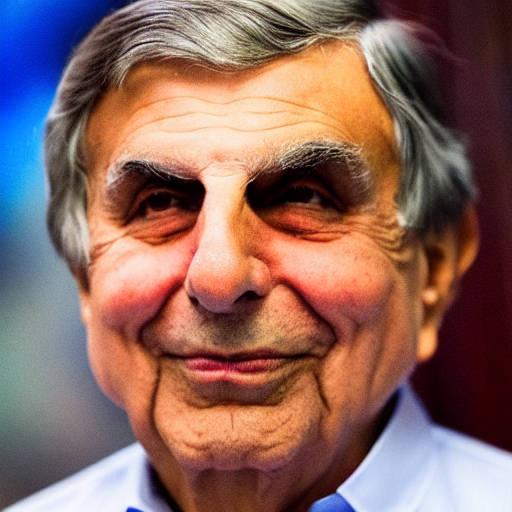

In [23]:
pipe.unet.eval()

image = pipe(
    "a high quality photo of Ratan tata ",
    num_inference_steps=30
).images[0]

image
